In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import minimize
import pandas as pd
import os
os.chdir('/home/oscar/Montecarlo-for-hadronic/')

df = pd.read_csv("2-particles.dat", 
                 delim_whitespace=True,     # Usa cualquier espacio como separador
                 header=None,               # No hay encabezados
                 names=["E", "px", "py", "pz"])  # Nombres de columnas

/tmp/ipykernel_393234/898536536.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("2-particles.dat",


In [4]:
df.head()

,E,px,py,pz
0,0.290182,0.00000,0.000000,0.256867
1,0.290182,-0.19150,0.110913,-0.130409
2,0.972535,0.19150,-0.110913,0.130409
3,0.260117,0.00000,0.000000,0.222342
4,0.260117,0.20398,-0.073869,0.048697


Reconstruimos las variables de Mandelstam, teniendo en cuenta que en cada grupo de tres, el primero es el fotón el segundo es el pión y el tercero es el protón.

In [5]:
n = 3  # Tamaño de bloque

# Crear una lista donde cada elemento es un bloque de 3 filas
grupos = [df.iloc[i:i+n].reset_index(drop=True) for i in range(0, len(df), n)]

# Ejemplo: acceder al grupo 0
grupos[0]

,E,px,py,pz
0,0.290182,0.0000,0.000000,0.256867
1,0.290182,-0.1915,0.110913,-0.130409
2,0.972535,0.1915,-0.110913,0.130409


In [6]:
s_var = []
t_var = []

for idx in range(len(grupos)):

    p_1 = grupos[idx].iloc[0].values ### FOTON
    p_a = grupos[idx].iloc[1].values ### PION
    p_b = grupos[idx].iloc[2].values ### PROTON

    p_s = p_a - p_b
    p_t = p_a - p_1

    s = p_s[0]**2 - (p_s[1:4]**2).sum()
    t = p_t[0]**2 - (p_t[1:4]**2).sum()

    s_var.append(s)
    t_var.append(t)

In [7]:
# Constantes físicas
M = 0.938    # Masa del protón en GeV
m_pi0 = 0.135 # Masa del pión neutro en GeV
hbarc2 = 0.3894 # Factor de conversión GeV^-2 a μb (microbarns)
#s = (8.0 + M)**2
# Parámetros del modelo de Regge (Mathieu et al. 2015)
# Trayectorias (Ecuación 23)
alpha_V0 = 0.44      # Intercepto vectorial
alpha_V_prime = 0.93 # Pendiente vectorial (GeV^-2)
alpha_A0 = -0.22     # Intercepto axial
alpha_A_prime = 1.08 # Pendiente axial (GeV^-2)
alpha_c0 = 0.9       # Intercepto del corte
alpha_c_prime = 0.2  # Pendiente del corte (GeV^-2)

# Acoplamientos (Ecuación 24)
g1 = -0.14    # GeV^-2 (acoplamiento vectorial helicidad-flip)
g2 = -9.74    # GeV^-4 (acoplamiento axial)
g4 = 3.98     # GeV^-2 (acoplamiento vectorial helicidad-nonflip)
g1c = 0.24    # GeV^-2 (corte vectorial helicidad-flip)
g4c = -0.13   # GeV^-2 (corte vectorial helicidad-nonflip)

# Escala de energía
s0 = 1.0    # GeV^2 (parámetro de escala)

def alpha_V(t):
    """Trayectoria para intercambios vectoriales (ω y ρ)"""
    return alpha_V0 + alpha_V_prime * t

def alpha_A(t):
    """Trayectoria para intercambios axiales (b y h)"""
    return alpha_A0 + alpha_A_prime * t

def alpha_c(t):
    """Trayectoria para el corte Regge-Pomerón"""
    return alpha_c0 + alpha_c_prime * t

def regge_amplitude(s, t, alpha_traj):
    """
    Amplitud de Regge completa (Ecuación 11 del artículo)
    
    Args:
        s: Mandelstam s (GeV^2)
        t: Mandelstam t (GeV^2)
        alpha_traj: Función de trayectoria (alpha_V, alpha_A o alpha_c)
    
    Returns:
        Amplitud compleja de Regge
    """
    # Término gamma para eliminar polos no físicos
    
    gamma_term = np.pi / gamma(alpha_traj(t))
    # Factor de firma (1 - e^{-iπα})/(2 sin πα)  
    alpha = alpha_traj(t) + 1e-6  
    signature = (1 - np.exp(-1j * np.pi * alpha)) / (2 * np.sin(np.pi * alpha))
    
    # Dependencia energética (s/s0)^{α(t)-1}
    energy_dep = (s / s0)**(alpha - 1)
    
    return gamma_term * signature * energy_dep

def regge_cut(s, t, alpha_traj):
    """
    Corte Regge-Pomerón (Ecuación 12 del artículo)
    Similar a la amplitud de Regge pero con factor logarítmico adicional
    """
    log_term = 1.0 / np.log(s / s0)
    return log_term * regge_amplitude(s, t, alpha_traj)
    
def F1(s, t):
    """Amplitud invariante F1 (Ecuación 15, contribución vectorial + corte)"""
    RV = regge_amplitude(s, t, alpha_V)
    Rc = regge_cut(s, t, alpha_c)
    return (-g1*t + 2*M*g4)*RV + (-g1c*t + 2*M*g4c)*Rc

def F2(s, t):
    """Amplitud invariante F2 (Ecuación 15, contribución axial)"""
    RA = regge_amplitude(s, t, alpha_A)
    return g2 * t * RA

def F3(s, t):
    """Amplitud invariante F3 (Ecuación 15, contribución vectorial + corte)"""
    RV = regge_amplitude(s, t, alpha_V)
    Rc = regge_cut(s, t, alpha_c)
    return (2*M*g1 - g4)*t*RV + (2*M*g1c - g4c)*t*Rc

def F4(s, t):
    """Amplitud invariante F4 (despreciada en el modelo)"""
    return 0.0 + 0.0j

In [8]:
def seccion_eficaz(s, t, M):

    return 1 / 32*np.pi * ( ( abs(F3(s,t))**2 - t*abs(F1(s,t))**2) / ( 4 * M**2 - t ) + abs(F2(s,t))**2 - t*abs(F4(s,t))**2 )

In [9]:
dsigma_dt = []

for i in range(len(grupos)):

    dsigma_dt.append(seccion_eficaz(s_var[i],t_var[i],M))

/tmp/ipykernel_393234/242641454.py:57: RuntimeWarning: invalid value encountered in scalar power
  energy_dep = (s / s0)**(alpha - 1)
/tmp/ipykernel_393234/242641454.py:66: RuntimeWarning: invalid value encountered in log
  log_term = 1.0 / np.log(s / s0)


(array([4.274e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([2.10448945e-06, 2.81456262e+14, 5.62912524e+14, 8.44368786e+14,
        1.12582505e+15, 1.40728131e+15, 1.68873757e+15, 1.97019384e+15,
        2.25165010e+15, 2.53310636e+15, 2.81456262e+15]),
 <BarContainer object of 10 artists>)

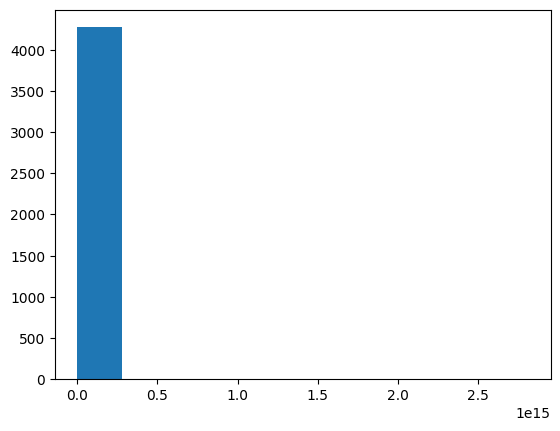

In [10]:
plt.hist(dsigma_dt)